In [19]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path


In [20]:
# Load lorenz data and check dimensions
data_filename = Path('../data/lorenz_training.npy')
if not data_filename.exists():
    raise FileNotFoundError(f"Data file {data_filename} not found.")
lorenz_data_training = np.load(data_filename)
# Check the shape of the data
print(f"Data shape: {lorenz_data_training.shape}")
if lorenz_data_training.ndim != 2:
    raise ValueError(f"Expected 2D array, got {lorenz_data_training.ndim}D array.")

Data shape: (5001, 3)


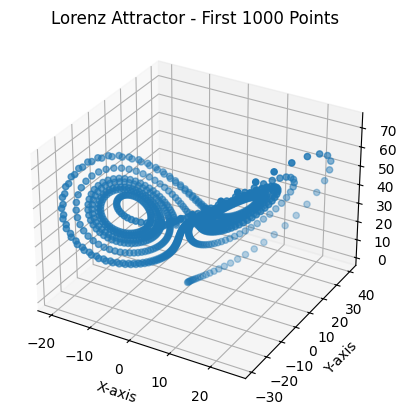

In [21]:
# lorenz data exploration
# plot the first 1000 points, 3 dimensional plot
import matplotlib.pyplot as plt
# Scatter plot of the first 1000 points in 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lorenz_data_training[:1000, 0], lorenz_data_training[:1000, 1], lorenz_data_training[:1000, 2])
plt.title('Lorenz Attractor - First 1000 Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


Validation data shape: (5000, 3)


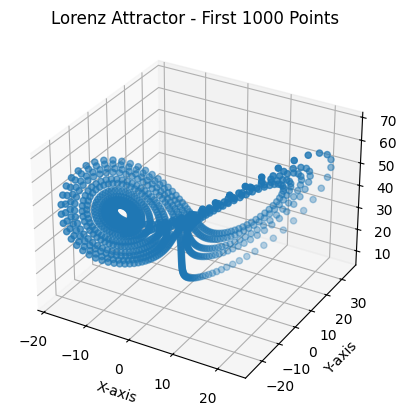

In [22]:
# Load vallidation data and check dimensions
data_filename = Path('../data/lorenz_truth.npy')
if not data_filename.exists():
    raise FileNotFoundError(f"Data file {data_filename} not found.")
lorenz_data_validation = np.load(data_filename)
# Check the shape of the data
print(f"Validation data shape: {lorenz_data_validation.shape}")
if lorenz_data_validation.ndim != 2:
    raise ValueError(f"Expected 2D array, got {lorenz_data_validation.ndim}D array.")
# lorenz data exploration
# plot the first 1000 points, 3 dimensional plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lorenz_data_validation[:1000, 0], lorenz_data_validation[:1000, 1], lorenz_data_validation[:1000, 2])
plt.title('Lorenz Attractor - First 1000 Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [23]:
# downsample the data
downsample_factor = 1
lorenz_data_training_original = lorenz_data_training.copy()
lorenz_data_validation_original = lorenz_data_validation.copy()

lorenz_data_training = lorenz_data_training[::downsample_factor]
lorenz_data_validation = lorenz_data_validation[::downsample_factor]
# lorenz_data_training = lorenz_data_training[::10]
# lorenz_data_validation = lorenz_data_validation[::10]

In [24]:
# Simple MLP model that takes in 3 inputs and outputs 3 values
class MLP(nn.Module):
    def __init__(self, input_dim=3, output_dim=3, hidden_dim=64):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
# Torch dataloader
class LorenzDataset(torch.utils.data.Dataset):
    def __init__(self, data, input_steps=1, output_steps=1, flatten=False, downsample_factor=1):
        self.data = data
        self.output_steps = output_steps
        self.input_steps = input_steps
        self.flatten = flatten
        if data.ndim != 2:
            raise ValueError(f"Expected 2D array, got {data.ndim}D array.")
        if data.shape[1] != 3:
            raise ValueError(f"Expected 3 features, got {data.shape[1]} features.")
        if input_steps + output_steps > len(data):
            raise ValueError("Input and output steps exceed data length.")

    def __len__(self):
        return len(self.data) - self.output_steps - self.input_steps +1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.input_steps]
        if self.flatten:
            x = x.flatten()
        y = self.data[idx + self.input_steps:idx + self.input_steps + self.output_steps]
        if self.flatten:
            y = y.flatten()
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [26]:
# Test dataset and dataloader
lorenz_dataset = LorenzDataset(lorenz_data_training, input_steps=5,output_steps=1, flatten=True)
lorenz_dataloader = torch.utils.data.DataLoader(lorenz_dataset, batch_size=16, shuffle=True)
print(f"Number of batches: {len(lorenz_dataloader)}")
# Sample a few batches
for i, (x, y) in enumerate(lorenz_dataloader):
    print(f"Batch {i}:")
    print(f"x: {x.shape}, y: {y.shape}")
    if i == 2:  # Just show a few batches
        break

Number of batches: 313
Batch 0:
x: torch.Size([16, 15]), y: torch.Size([16, 3])
Batch 1:
x: torch.Size([16, 15]), y: torch.Size([16, 3])
Batch 2:
x: torch.Size([16, 15]), y: torch.Size([16, 3])


In [27]:
input_steps = 1
output_steps = 1
n_features = lorenz_data_training.shape[1]

# Initialize the model
model = MLP(input_dim=input_steps * n_features, output_dim=output_steps * n_features, hidden_dim=128)
# Print model summary
def print_model_summary(model):
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")



In [28]:
# Dataloaders
batch_size = 32
training_dataset = LorenzDataset(lorenz_data_training, input_steps=input_steps,output_steps=output_steps, flatten=True)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_dataset = LorenzDataset(lorenz_data_validation, input_steps=input_steps,output_steps=output_steps, flatten=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [29]:
# Evaluate the model autoregressively
def evaluate_model_autoregressive(model, data, input_steps=5, output_steps=1,):
    model.eval()
    with torch.no_grad():
        # Initialize the input with the first input_steps data points
        x = torch.tensor(data[:input_steps], dtype=torch.float32)
        preds=x
        # print(f"Initial input shape: {x.shape}")
        predictions = []
        print(f"Data shape: {data.shape}")
        print(f"range: {(len(data) - input_steps)// output_steps}")
        for _ in range((len(data) - input_steps)// output_steps +1):
            y_pred = model(x.flatten().unsqueeze(0))
            # print(f"Predicted shape: {y_pred.shape}")
            
            # Reshape the prediction to match the output shape
            y_pred = y_pred.reshape(output_steps, 3)
            # print(f"Predicted shape: {y_pred.shape}")
            # print(f"Predictions shape: {np.array(predictions[0]).shape}")
            # Update the input with the new prediction
            # Concatenate the new prediction to the input
            x = torch.cat((x, y_pred), dim=0)[-input_steps:]
            preds = torch.cat((preds, y_pred), dim=0)
        # Accumulate the predictions
        # preds = np.empty(data.shape)
        print(f"Preds shape: {preds.shape}")
        # preds[:input_steps] = data[:input_steps]
        # for i in range(len(predictions)):
        #     print(f"Ind1:  {input_steps+i*output_steps}")
        #     print(input_steps+(i+1)*output_steps)
        #     preds[input_steps+i*output_steps:input_steps+(i+1)*output_steps] = predictions[i]
        # Reduce the predictions to the original shape
        preds = preds[:data.shape[0]]
        # Convert to numpy array
    return preds

In [ ]:
loss_fn = nn.MSELoss()
loss_fn_test = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
# Training loop using tqdm
num_epochs = 1000
num_epochs_validation = 50

test_data = np.concat((lorenz_data_training, lorenz_data_validation), axis=0)
test_data = test_data[-(len(lorenz_data_validation)+input_steps):]
from tqdm import tqdm
from tqdm import trange
# Training loop
pbar = trange(num_epochs, desc="Training", unit="epoch")
for epoch in pbar:
    model.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(training_dataloader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()

    pbar.set_postfix(loss=running_loss / len(training_dataloader))
    # Validation loop
    if epoch % num_epochs_validation == 0:
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for i, (x, y) in enumerate(validation_dataloader):
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                validation_loss += loss.item()
        preds = evaluate_model_autoregressive(model, test_data, input_steps=input_steps, output_steps=output_steps)
        print(f"Preds outside shape: {preds.shape}")
        print(f"Test data shape: {test_data.shape}")
        loss = loss_fn_test(preds.unsqueeze(0), torch.tensor(test_data.unsqueeze(0)))
        test_loss = loss.item()
        print(f"Test loss: {test_loss}")
        print(f"Validation loss: {validation_loss / len(validation_dataloader)}")



Training:   0%|          | 0/1000 [00:00<?, ?epoch/s, loss=1.04]


Data shape: (5001, 3)
range: 5000
Preds shape: torch.Size([5002, 3])
Preds outside shape: torch.Size([5001, 3])
Test data shape: (5001, 3)


AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [ ]:
# Evaluate the model autoregressively
def evaluate_model_autoregressive(model, data, input_steps=5, output_steps=1,):
    model.eval()
    with torch.no_grad():
        # Initialize the input with the first input_steps data points
        x = torch.tensor(data[:input_steps], dtype=torch.float32)
        preds=x
        # print(f"Initial input shape: {x.shape}")
        predictions = []
        print(f"Data shape: {data.shape}")
        print(f"range: {(len(data) - input_steps)// output_steps}")
        for _ in range((len(data) - input_steps)// output_steps +1):
            y_pred = model(x.flatten().unsqueeze(0))
            # print(f"Predicted shape: {y_pred.shape}")
            
            # Reshape the prediction to match the output shape
            y_pred = y_pred.reshape(output_steps, 3)
            # print(f"Predicted shape: {y_pred.shape}")
            # print(f"Predictions shape: {np.array(predictions[0]).shape}")
            # Update the input with the new prediction
            # Concatenate the new prediction to the input
            x = torch.cat((x, y_pred), dim=0)[-input_steps:]
            preds = torch.cat((preds, y_pred), dim=0)
        # Accumulate the predictions
        # preds = np.empty(data.shape)
        print(f"Preds shape: {preds.shape}")
        # preds[:input_steps] = data[:input_steps]
        # for i in range(len(predictions)):
        #     print(f"Ind1:  {input_steps+i*output_steps}")
        #     print(input_steps+(i+1)*output_steps)
        #     preds[input_steps+i*output_steps:input_steps+(i+1)*output_steps] = predictions[i]
        # Reduce the predictions to the original shape
        preds = preds[:data.shape[0]]
        # Convert to numpy array
        preds = preds.numpy()
    return preds

In [ ]:
print(len(training_dataset[0]), len(training_dataset[0][0]), len(training_dataset[0][1]))
data = np.concat((lorenz_data_training, lorenz_data_validation), axis=0)
data = data[-(len(lorenz_data_validation)+input_steps):]
print(f"Data shape: {data.shape}")
# Evaluate the model
preds = evaluate_model_autoregressive(model, data, input_steps=input_steps, output_steps=output_steps)
print(f"Predictions shape: {preds.shape}")

2 3 3
Data shape: (2501, 3)
Data shape: (2501, 3)
range: 2500
Preds shape: torch.Size([2502, 3])
Predictions shape: (2501, 3)


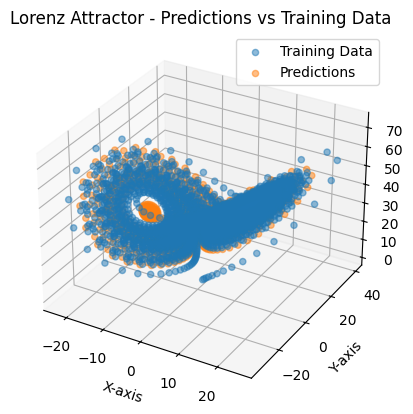

In [ ]:
# Plot the predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lorenz_data_training[:10000, 0], lorenz_data_training[:10000, 1], lorenz_data_training[:10000, 2], label='Training Data', alpha=0.5)
ax.scatter(preds[:10000, 0], preds[:10000, 1], preds[:10000, 2], label='Predictions', alpha=0.5)
plt.title('Lorenz Attractor - Predictions vs Training Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

In [ ]:
def scoring_lorenz(truth, prediction, k=20, modes=100):
    '''produce long-time and short-time error scores.'''
    [m,n]=truth.shape
    Est = np.linalg.norm(truth[:,0:k]-prediction[:,0:k],2)/np.linalg.norm(truth[:,0:k],2)

    yt = truth[-modes:, :]
    M = np.arange(-30, 31, 1)
    M2 = np.arange(0, 71, 1)
    yhistxt, xhistx = np.histogram(yt[:, 0], bins=M)
    yhistyt, xhisty = np.histogram(yt[:, 1], bins=M)
    yhistzt, xhistz = np.histogram(yt[:, 2], bins=M2)

    yp = prediction[-modes:, :]
    yhistxp, xhistx = np.histogram(yp[:, 0], bins=M)
    yhistyp, xhisty = np.histogram(yp[:, 1], bins=M)
    yhistzp, xhistz = np.histogram(yp[:, 2], bins=M2)

    Eltx = np.linalg.norm(yhistxt-yhistxp,2)/np.linalg.norm(yhistxt,2)
    Elty = np.linalg.norm(yhistyt-yhistyp,2)/np.linalg.norm(yhistyt,2)
    Eltz = np.linalg.norm(yhistzt-yhistzp,2)/np.linalg.norm(yhistzt,2)

    Elt =  (Eltx+Elty+Eltz)/3

    E1 = 100*(1-Est)
    E2 = 100*(1-Elt)

    if np.isnan(E1):
        E1 = -np.inf
    if np.isnan(E2):
        E2 = -np.inf

    return E1, E2

print(type(preds))
print(type(lorenz_data_validation))
scores = scoring_lorenz(lorenz_data_validation, preds[-(lorenz_data_validation.shape[0]):], k=20, modes=100)
print(f"Short-time error score: {scores[0]}")
print(f"Long-time error score: {scores[1]}")


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Short-time error score: 46.89479761366553
Long-time error score: -365.7939377427417


Data shape: (2501, 3)
range: 2500
Preds shape: torch.Size([2502, 3])
Data shape: (2501, 3)
range: 2500
Preds shape: torch.Size([2502, 3])
Predictions shape: (5002, 3)


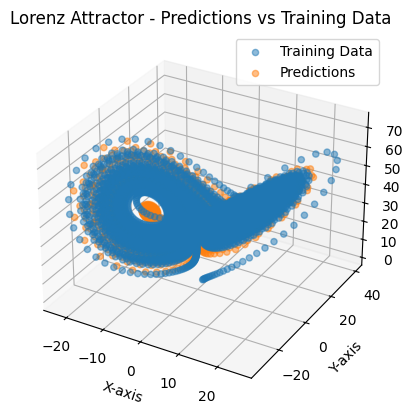

In [ ]:
# Evaluate model trained with downsampled data on original data
if downsample_factor != 1:
    data = np.concat((lorenz_data_training_original, lorenz_data_validation_original), axis=0)
    data = data[-(len(lorenz_data_validation_original)+input_steps*downsample_factor):]
    preds = np.empty(data.shape)
    for i in range(downsample_factor):
        data_down = data[i::downsample_factor]
        # print(f"Data shape: {data_down.shape}")
        # Evaluate the model
        pred = evaluate_model_autoregressive(model, data_down, input_steps=input_steps, output_steps=output_steps)
        # print(f"Predictions shape: {pred.shape}")
        preds[i::downsample_factor] = pred
    # Plot the predictions 
    print(f"Predictions shape: {preds.shape}") 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(lorenz_data_training_original[:10000, 0], lorenz_data_training_original[:10000, 1], lorenz_data_training_original[:10000, 2], label='Training Data', alpha=0.5)
    ax.scatter(preds[:10000, 0], preds[:10000, 1], preds[:10000, 2], label='Predictions', alpha=0.5)
    plt.title('Lorenz Attractor - Predictions vs Training Data')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()
    
        
        



In [ ]:
scores = scoring_lorenz(lorenz_data_validation_original, preds[-(lorenz_data_validation_original.shape[0]):], k=20, modes=100)
print(f"Short-time error score: {scores[0]}")
print(f"Long-time error score: {scores[1]}")

Short-time error score: 45.24310135695695
Long-time error score: -336.8888060420806
